
# Elección de la mejor predición


VAmos a trabajar con las sigueinte  __Series de tiempos __ que nos da ventas mensuales de coles en Quebec desde 1960 hasta 1968. Este dataset puede ser bajado de aquí: 

<https://datamarket.com/data/set/22n4/monthly-car-sales-in-quebec-1960-1968>

El objetivo de este notebook es explorar diferentes modelos para predecir 
las ventas futuras. 

Seguiremos los siguientes pasos:

1. Preparación de datos.
2. Separar los datos en entrenamiento, test y validación.
3. Construir los diferentes modelos.
4. Ajustar los modelos o a los datos de entrenamiento.
5. Evaluar cada modelo en el conjunto de valildación y elegir el mejor.
6. Evaluar el modelo en el conjunto de test.

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rc('xtick', labelsize=20)     
plt.rc('ytick', labelsize=20)

### Preparación de datos

In [3]:
cars_df = pd.read_csv("/home/ainhoa/Master/Datasets/monthly-car-sales-in-quebec-1960.csv", header=0)
cars_df.tail()

,Month,Monthly car sales in Quebec 1960-1968
104,1968-09,14385.0
105,1968-10,21342.0
106,1968-11,17180.0
107,1968-12,14577.0
108,Monthly car sales in Quebec 1960-1968,NaN


Limpiamos última fila

In [4]:
cars_df = cars_df.iloc[:-1]

Cambiamos el formato de las fechas

In [5]:
cars_df["dt"] = cars_df["Month"].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m'))

Renombramos la columna `Monthly car sales in Quebec 1960-1968` por  `sales` y eliminamos la columna `Month`.

In [6]:
cars_df = cars_df\
    .rename({"Monthly car sales in Quebec 1960-1968": "sales"}, axis=1)\
    .drop("Month", axis=1)
cars_df.tail()

,sales,dt
103,16722.0,1968-08-01
104,14385.0,1968-09-01
105,21342.0,1968-10-01
106,17180.0,1968-11-01
107,14577.0,1968-12-01


Dibujamos nuestra serie de tiempos:

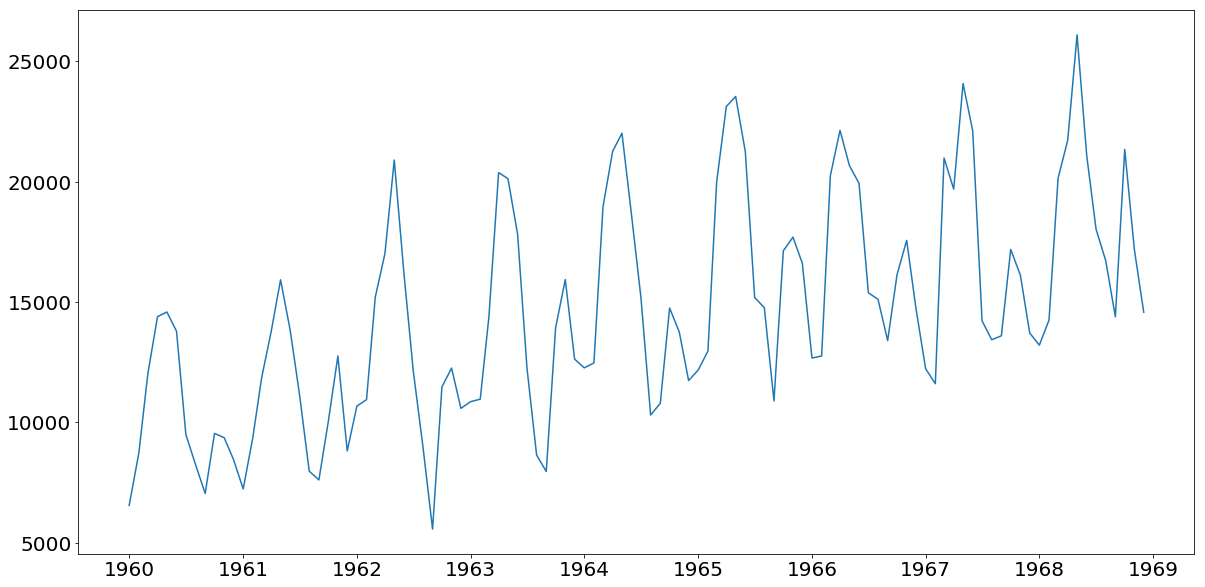

In [7]:
plt.plot(cars_df["dt"], cars_df["sales"])

Verificamos que tenemos datos de todos los meses:

In [8]:
cars_df[['dt']].groupby(cars_df["dt"].dt.year).count()

,dt
dt,
1960,12
1961,12
1962,12
1963,12
1964,12
1965,12
1966,12
1967,12
1968,12


## Separar los datos en entrenamiento, test y validación.


* Mucho cuidado que cuando trabajamos series de tiempos no podemos hacer el split aleatoriamente ya que se trata de predecir datos a futuro. Por tanto tenemos respetar que el conjunto de validación y test son usando datos posteriores al conjunto de entrenamiento.

In [10]:
#En series temporales, al dividir el conjunto de datos en train, validation y test, hay que asegurarse de que
#cada conjunto abarca ciertos años, y no todos aleatoriamente.
Xy = cars_df[['dt', 'sales']]

def create_X_and_y(Xy, target_column='sales'):
    return Xy.drop(target_column, axis=1), Xy[target_column]

def split_into_train_dev_test(Xy):
    X_train, y_train = create_X_and_y(Xy.query("dt < '1967' "))
    X_dev, y_dev = create_X_and_y(Xy.query("dt >= '1967' and dt < '1968'"))
    X_test,y_test = create_X_and_y(Xy.query("dt >= '1968'"))
    return X_train, X_dev, X_test, y_train, y_dev, y_test

X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy)

## Modelo 1: media de las anteriores ventas


Un simple modelo es predecir a futuro el valor de la media de los datos anteriores.

In [37]:
y_dev_hat = np.ones(len(y_dev))*y_train.mean()
y_dev_hat

array([13792.35714286, 13792.35714286, 13792.35714286, 13792.35714286,
       13792.35714286, 13792.35714286, 13792.35714286, 13792.35714286,
       13792.35714286, 13792.35714286, 13792.35714286, 13792.35714286])

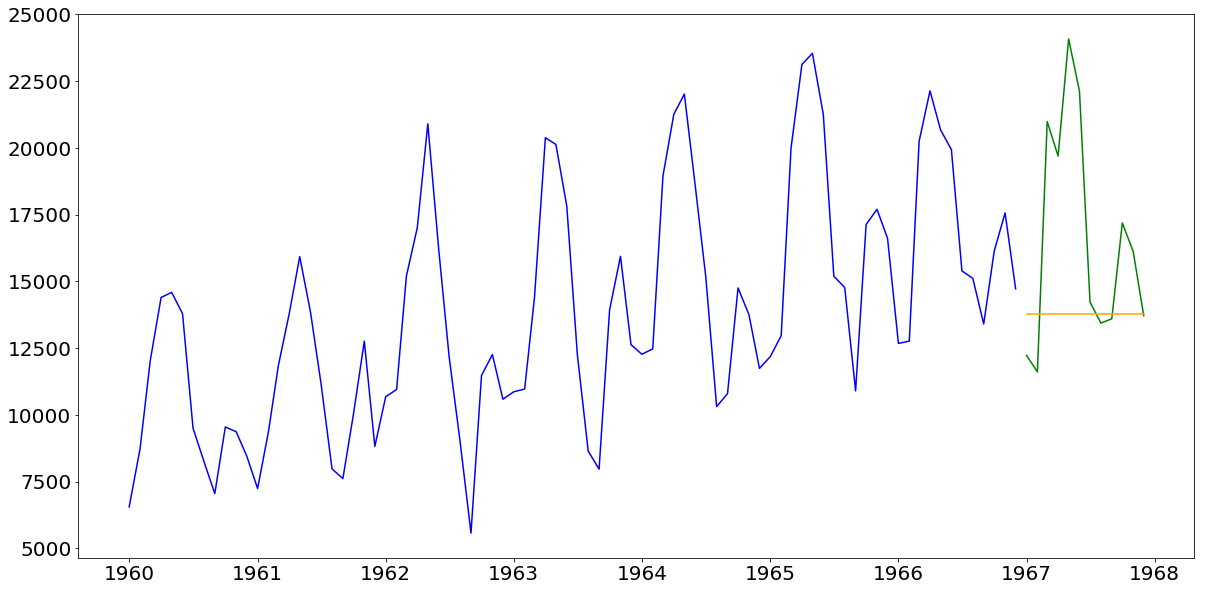

In [41]:
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')

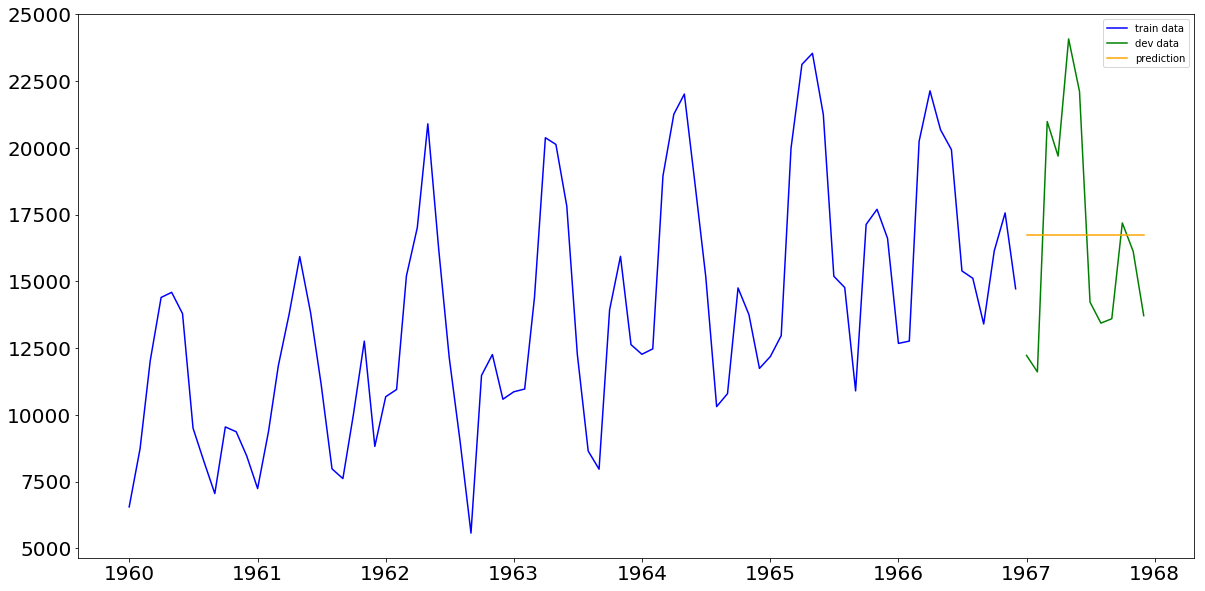

In [49]:
def plot_prediction(X_train, y_train, X_dev, y_dev, y_dev_hat):
    plt.plot(X_train["dt"], y_train, c="blue", label='train data')
    plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
    plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
    plt.legend()
    plt.show()
plot_prediction(X_train, y_train, X_dev, y_dev, y_dev_hat)

Vemos que la predición no es buena, pero nos sirve para tener un __baseline__, un punto de comienzo para ir mejorando con otros modelos.

Para la evaluación del performance del modelo usaremos el error cuadrático medio, MSE, y su raiz, RSME que nos servirán para elegir el mejor modelo.

In [28]:
from sklearn.metrics import mean_squared_error

print("MSE: " ,mean_squared_error(y_dev, y_dev_hat))
print("RMSE: ", np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

MSE:  23847172.57993197
RMSE:  4883.356691859808


## Modelo 2: media del año anterior

Vamos a tomar la media de los últimos doce meses

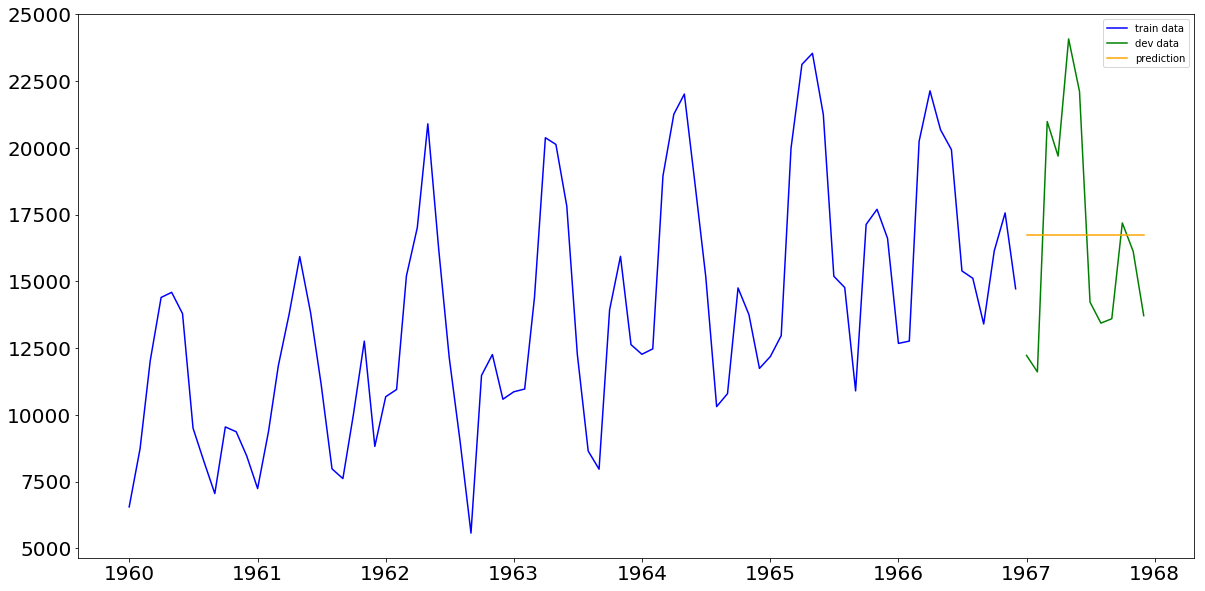

In [50]:
y_dev_hat = np.ones(len(y_dev)) * y_train[-12:].mean()
plot_prediction(X_train, y_train, X_dev, y_dev, y_dev_hat)

This time it looks better.

In [51]:
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

4011.3046791744287

##  Modelo 3: valor del mes anterior


A menudo, para predecir el valor del siguiente mes, usamos el valor del anterior mes. Para ello vamos a añadir una nueva feature que nos da el valor del mes anterior usando el método en python llamado `shift`. esto es llamado __lag__.

In [62]:
Xy_with_lags = Xy.copy()
Xy_with_lags['sales-1'] = Xy_with_lags['sales'].shift(1)
Xy_with_lags.head()

,dt,sales,sales-1
0,1960-01-01,6550.0,NaN
1,1960-02-01,8728.0,6550.0
2,1960-03-01,12026.0,8728.0
3,1960-04-01,14395.0,12026.0
4,1960-05-01,14587.0,14395.0


In [63]:
X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy_with_lags)

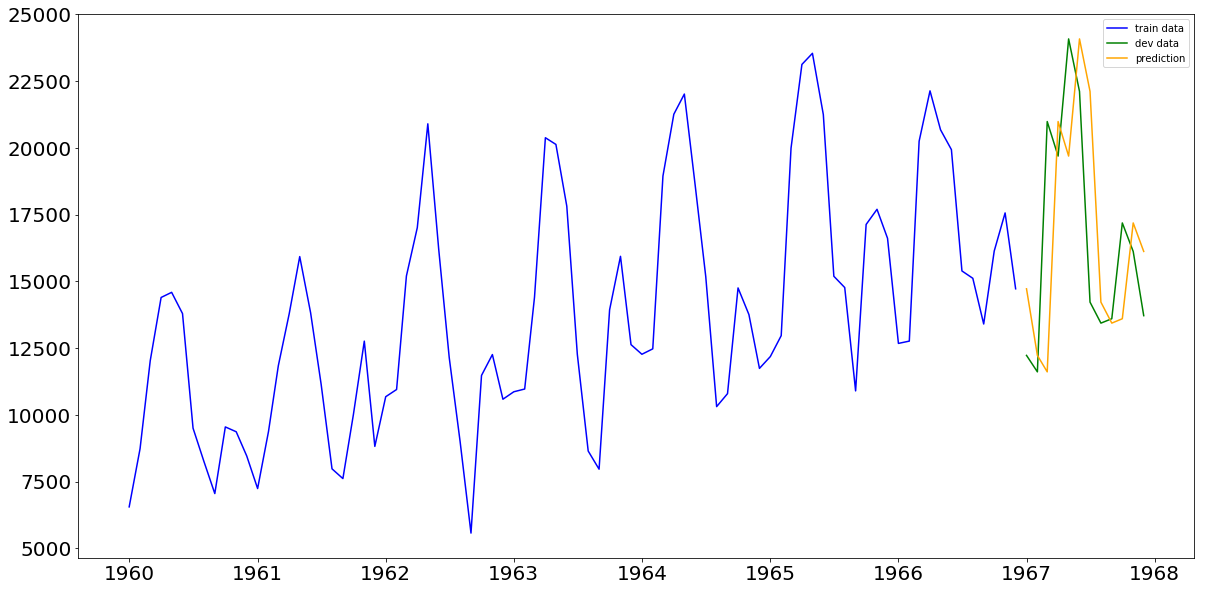

In [64]:
y_dev_hat = X_dev[['sales-1']]
plot_predicition(X_train, y_train, X_dev, y_dev, y_dev_hat)

In [65]:
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

4103.945367976203

##  Modelo 4: modelo de Autoregresion (AR)


Es claro que los datos de Diciembre de un año y el anterior están correlacionados. Vamos a calcular si es cierto haciendo la función de correlación entre un periodo y el de un año anterior (usaremos lags).

In [68]:
N_lags = 12

def create_lags(Xy, n_lags):
    Xy_with_lags = Xy.copy()
    for i in range(1, n_lags+1):
        Xy_with_lags['sales-'+str(i)] = Xy_with_lags['sales'].shift(i)
    return Xy_with_lags

Xy_with_lags = create_lags(Xy, N_lags)
autocorrelations = Xy_with_lags.iloc[N_lags:].drop("dt", axis=1).corr()['sales']

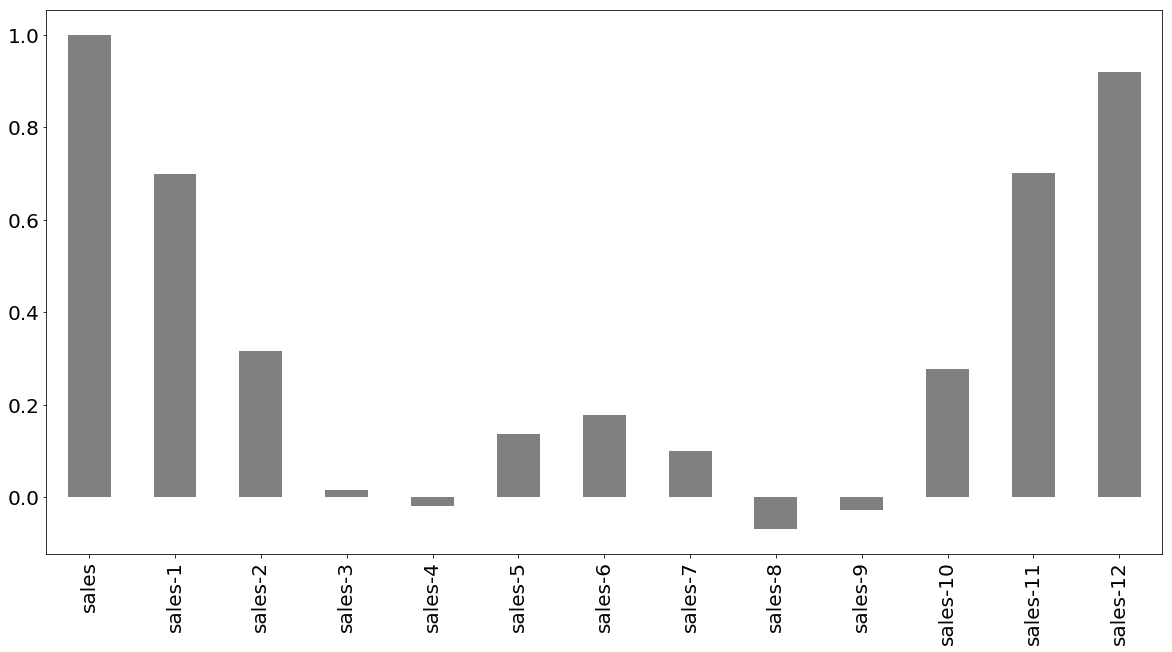

In [78]:
autocorrelations.plot(kind='bar',color='gray')

Elegimos las columnas que son más correladas con sales.

In [70]:
Xy_with_lags(['sales', 'sales-1', 'sales-11'], axis=1).copy()

,dt,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7,sales-8,sales-9,sales-10,sales-12
0,1960-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1960-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1960-03-01,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1960-04-01,8728.0,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1960-05-01,12026.0,8728.0,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1960-06-01,14395.0,12026.0,8728.0,6550.0,NaN,NaN,NaN,NaN,NaN,NaN
6,1960-07-01,14587.0,14395.0,12026.0,8728.0,6550.0,NaN,NaN,NaN,NaN,NaN
7,1960-08-01,13791.0,14587.0,14395.0,12026.0,8728.0,6550.0,NaN,NaN,NaN,NaN
8,1960-09-01,9498.0,13791.0,14587.0,14395.0,12026.0,8728.0,6550.0,NaN,NaN,NaN
9,1960-10-01,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0,8728.0,6550.0,NaN,NaN


Eliminamos los Nas de los lags y construimos un modelo lineal

In [77]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(Xy_with_lags[['sales', 'sales-11', 'sales-1']].dropna(),Xy_with_lags['sales'])

ValueError: Found input variables with inconsistent numbers of samples: [97, 108]

In [ ]:
plot_predicition(X_train, y_train, X_dev, y_dev, y_dev_hat)

Ahora hemos mejorado más que el doble!!!!

##  Modelo 5: modelo recurrente 

A menudo en la práctica nosotros buscamos una predición para todo el año. Vamos a asumir que estamos en Enero de 1967 y nos gustaria tener una previsión par todos los meses de 1967 y así la empresa podría optimizar el stock mensual.

Podemos hacer lo mismo que en el modelo anterior pero usando las prediciones anteriores. Esto significa que para predecir Abril usaremos los ultimos 12 meses últimos, tomando para Enero, Febreo y Marzo los datos de predicion. 

In [79]:
def recurrent_prediction(y_train, n_steps, reg):
    x_dev = list(y_train[-1:-(n_steps +1):-1])
    y_dev_hat = []
    for i in range(n_steps):
        y_hat = reg.predict([x_dev])[0]
        y_dev_hat.append(y_hat)
        x_dev.pop(-1)
        x_dev = [y_hat] + x_dev
    return y_dev_hat

y_dev_hat = recurrent_prediction(y_train, 12, reg_all_columns)
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

NameError: name 'reg_all_columns' is not defined

In [ ]:
plot_predicition(X_train, y_train, X_dev, y_dev, y_dev_hat)

##  Modelo 6: K-nearest neighborhood 

In [80]:
from sklearn.neighbors import KNeighborsRegressor

N_lags = 12
Xy_with_lags = create_lags(Xy, N_lags).iloc[N_lags:]
X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy_with_lags)

reg_kn = KNeighborsRegressor(n_neighbors=5)
reg_kn.fit(X_train.drop("dt", axis=1), y_train)
y_dev_hat = recurrent_prediction(y_train, N_lags, reg_kn)
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

1664.4863111482778

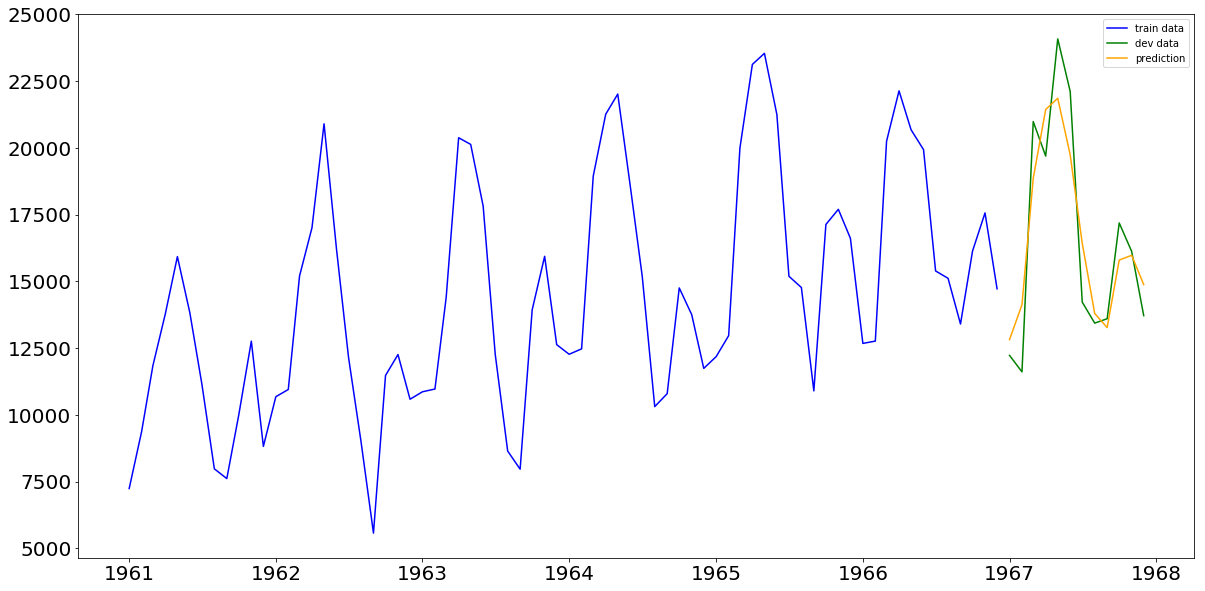

In [81]:
plot_predicition(X_train, y_train, X_dev, y_dev, y_dev_hat)

 Elige tu mejor modelo para el parámetro
 n_neighbors

In [87]:
for i in [1,2,3,4,5,6,7,8]:
    reg_kn = KNeighborsRegressor(n_neighbors=i)
    reg_kn.fit(X_train.drop("dt", axis=1), y_train)
    y_dev_hat = recurrent_prediction(y_train, N_lags, reg_kn)
    print('neighbors={} , RSME={}'.format(i, np.sqrt(mean_squared_error(y_dev, y_dev_hat))))

neighbors=1 , RSME=1653.4736919588408
neighbors=2 , RSME=1557.7931973896066
neighbors=3 , RSME=1866.014777044423
neighbors=4 , RSME=1659.9309144133078
neighbors=5 , RSME=1664.4863111482778
neighbors=6 , RSME=1902.0093699870456
neighbors=7 , RSME=1985.8576811020062
neighbors=8 , RSME=1838.954596806181


##  Modelo 7: Random Forest

In [88]:
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


reg_rf = RandomForestRegressor(random_state=667)
reg_rf.fit(X_train.drop("dt", axis=1), y_train)
y_dev_hat = recurrent_prediction(y_train, N_lags, reg_rf)
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

1563.6772125346079

Elige tu mejor modelo para los parámetros n_estimators y max_depth

In [94]:
X_train_dev = pd.concat([X_train, X_dev])
y_train_dev = np.concatenate([y_train, y_dev])

for i in [1,2,3,4,5,6,7,8]:
    for j in [1,2,3,4,5,6,7,8]:
        reg_rf = RandomForestRegressor(n_estimators=i ,max_depth=j , random_state=667)
        reg_rf.fit(X_train_dev.drop("dt", axis=1), y_train_dev)
        y_test_hat = recurrent_prediction(y_test, N_lags, reg_rf)
        print('max_depth={}, estimators={}, RSME={}'.format(j, i, np.sqrt(mean_squared_error(y_test, y_test_hat))))
        results = (j, i, np.sqrt(mean_squared_error(y_test, y_test_hat)))

max_depth=1, estimators=1, RSME=2387.2510188916194
max_depth=2, estimators=1, RSME=2385.3372080712866
max_depth=3, estimators=1, RSME=2483.250125460454
max_depth=4, estimators=1, RSME=2373.3499484572526
max_depth=5, estimators=1, RSME=3356.382806962728
max_depth=6, estimators=1, RSME=1617.0773585234178
max_depth=7, estimators=1, RSME=2706.594687227093
max_depth=8, estimators=1, RSME=2987.7605046812796
max_depth=1, estimators=2, RSME=2276.78378161151
max_depth=2, estimators=2, RSME=1694.1774380251911
max_depth=3, estimators=2, RSME=1497.1709989881363
max_depth=4, estimators=2, RSME=1810.9027581598032
max_depth=5, estimators=2, RSME=2240.453353950893
max_depth=6, estimators=2, RSME=1185.510016031935
max_depth=7, estimators=2, RSME=1902.4355358779692
max_depth=8, estimators=2, RSME=1833.3680172488332
max_depth=1, estimators=3, RSME=2347.8068396475483
max_depth=2, estimators=3, RSME=1892.2553886647995
max_depth=3, estimators=3, RSME=2262.2628131438173
max_depth=4, estimators=3, RSME=2341.1

In [ ]:
X_train_dev = pd.concat([X_train, X_dev])
y_train_dev = np.concatenate([y_train, y_dev])

reg_rf = RandomForestRegressor(n_estimators=#WRITE YOUR CODE,
                               max_depth=#WRITE YOUR CODE
                               , random_state=667)
reg_rf.fit(X_train_dev.drop("dt", axis=1), y_train_dev)
y_test_hat = recurrent_prediction(y_test, N_lags, reg_rf)
np.sqrt(mean_squared_error(y_test, y_test_hat))

In [ ]:
plot_predicition(X_train_dev, y_train_dev, X_test, y_test, y_test_hat)

## Modelo 8: Autoregression (AR) 

In [ ]:
from statsmodels.tsa.ar_model import AR
model = AR(y_train)
model_fit = model.fit(maxlag=12)
y_dev_hat = model_fit.predict(start=len(y_train), end=len(y_train)+11)    
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

In [ ]:
plot_predicition(X_train, y_train, X_dev, y_dev, y_dev_hat)

## Modelo 8: Autoregression Moving Average (ARIMA) 

In [ ]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(y_train, order=(9, 2))
model_fit = model.fit(disp=0, start_ar_lags=13)

In [ ]:
y_dev_hat = model_fit.predict(start=len(y_train), end=len(y_train)+11)    
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

In [ ]:
plot_predicition(X_train, y_train, X_dev, y_dev, y_dev_hat)

## Bibliography

https://machinelearningmastery.com/how-to-develop-a-skilful-time-series-forecasting-model/

https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc41.htm

https://www.it.uu.se/research/publications/reports/2006-022/2006-022-nc.pdf
http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016
